In [29]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
import pickle 
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [4]:
# load the data
data = pd.read_csv("Data/Real-Data/Real_Combine1.csv")
data.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [5]:
# drop the null values
data.dropna(inplace=True)

In [6]:
# check whether all null values are dropped
for column in data.columns:
    print(f"{column} has {data[column].isnull().sum()} null values")

T has 0 null values
TM has 0 null values
Tm has 0 null values
SLP has 0 null values
H has 0 null values
VV has 0 null values
V has 0 null values
VM has 0 null values
PM 2.5 has 0 null values


In [7]:
# split the data into dependent and independent features

X = data.iloc[:, :-1]
y = data.iloc[:,-1]

print(X.shape)
print(y.shape)

(1092, 8)
(1092,)


In [8]:
# split the data into train and test-sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [9]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(873, 8) (219, 8)
(873,) (219,)


In [10]:
# plot the top features based on feature importance
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [11]:
print(selection.feature_importances_)

[0.18763711 0.10478058 0.17331695 0.14802909 0.08925567 0.20308338
 0.05196029 0.04193692]


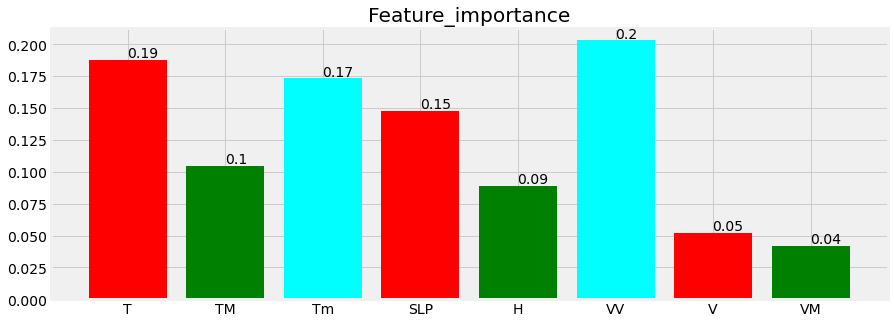

In [12]:
# Plot the feature importances using a barchart

feature_importance = selection.feature_importances_
columns = X.columns
plt.figure(figsize=(15, 5))
plt.style.use('fivethirtyeight')
plt.bar(columns, feature_importance, color=["red", "green", "cyan"])
for index, value in enumerate(feature_importance):
    plt.text(index - 0.005, value + 0.002, str(round(value, 2)))
plt.title("Feature_importance")
plt.show()

In [13]:
# Build a base model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [14]:
print(f"Train Data:{model.score(X_train, y_train)}")
print(f"Test Data:{model.score(X_test, y_test)}")

Train Data:0.9777678687561768
Test Data:0.7789453056533874


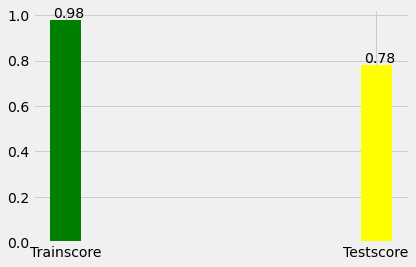

In [15]:
Train_score = model.score(X_train, y_train)
Test_score = model.score(X_test, y_test)

plt.figure()
plt.style.use('fivethirtyeight')
plt.bar(["Trainscore", "Testscore"], [Train_score, Test_score], width=0.1, color=["green", "yellow"])
for index, value in enumerate([Train_score, Test_score]):
    plt.text(index-0.04, value+0.01, str(round(value, 2)))
plt.show()

In [16]:
# visualize the model fitted lines
def plot_predictions(X_train, X_test, y_train, y_test, model):
    predictions = [model.predict(X_train), model.predict(X_test)]
    actual = [y_train, y_test]
    text = ["train-data", "test-data"]
    colors = ["red", "green", "cyan"]
    for i in range(len(predictions)):
        plt.figure(figsize=(15, 5))
        plt.scatter(actual[i], predictions[i], cmap='winter', color=random.choice(colors))
        plt.plot([actual[i].min(), actual[i].max()], [actual[i].min(), actual[i].max()], marker="o", 
                 linestyle="dashed")
        plt.title(f"{text[i]} actual vs predictions")
        plt.xlabel("Actual-values")
        plt.ylabel("Predicted-values")

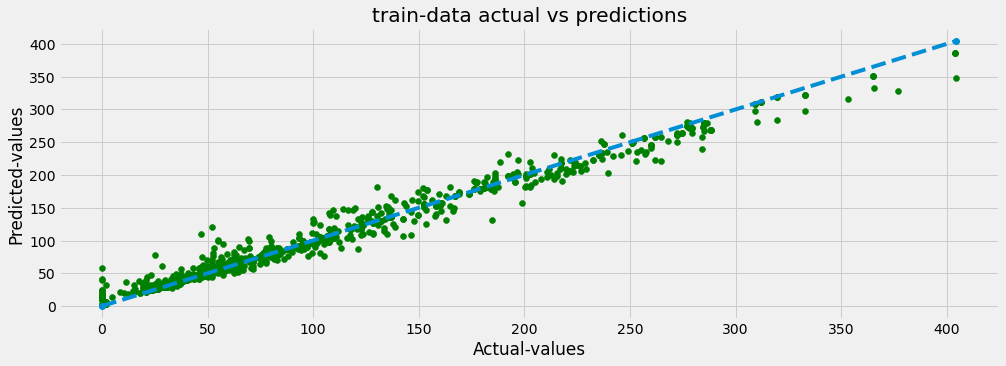

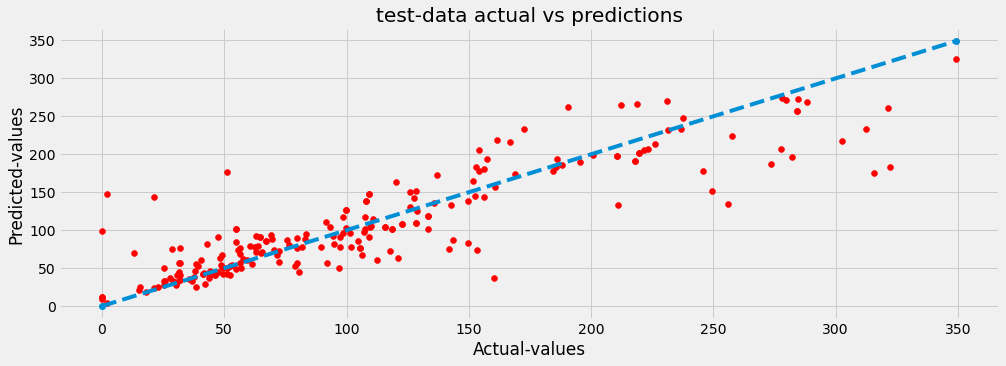

In [17]:
plot_predictions(X_train, X_test, y_train, y_test, model)

In [18]:
# lets try with cross validation
score = cross_val_score(model, X, y, cv=5)

In [19]:
score.mean()

0.7329843657442834

### We can clearly see that our model is undergoing overfitting

1. Lets do with Gridsearch cv
2. Randomized search cv

In [20]:
# Randomized search cv

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]

# number of features to consider every split
max_features = ['auto', 'sqrt']

# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]

# minimul number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# minimum number of samples required at each node
min_samples_leaf = [1, 2, 5, 10]

# create a random grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

# create the base model to tune
model = RandomForestRegressor()

# initialize the randomsearchcv
rf_model = RandomizedSearchCV(estimator=model,
                             param_distributions=random_grid,
                             scoring='neg_mean_squared_error',
                             n_iter=100,
                             cv=5,
                             verbose=2, random_state=42)
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_es

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   1.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, max_features

[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_featu

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   2.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=15, max_feature

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.3s
[CV] END max_depth=10, max_

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END max_depth=30,

[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.5s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_fe

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, m

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [24]:
rf_model.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

In [25]:
tuned_model = RandomForestRegressor(n_estimators=500,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   max_features='sqrt',
                                   max_depth=15)
tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=500)

In [26]:
print(f"Train:{tuned_model.score(X_train, y_train)}")
print(f"Train:{tuned_model.score(X_test, y_test)}")


Train:0.9778205958299726
Train:0.7413076802817582


In [27]:
with open('random_model.pkl',"wb") as file:
    pickle.dump(tuned_model, file)

## Xgboosting

In [31]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
regressor.score(X_test, y_test)

0.7839661116993322

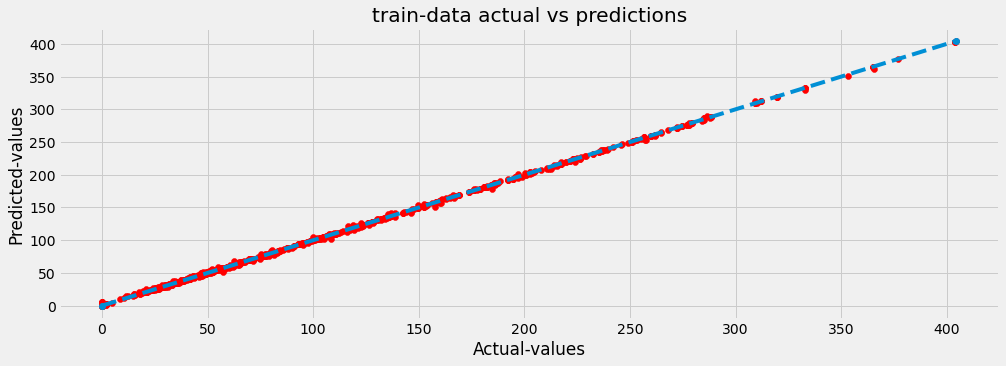

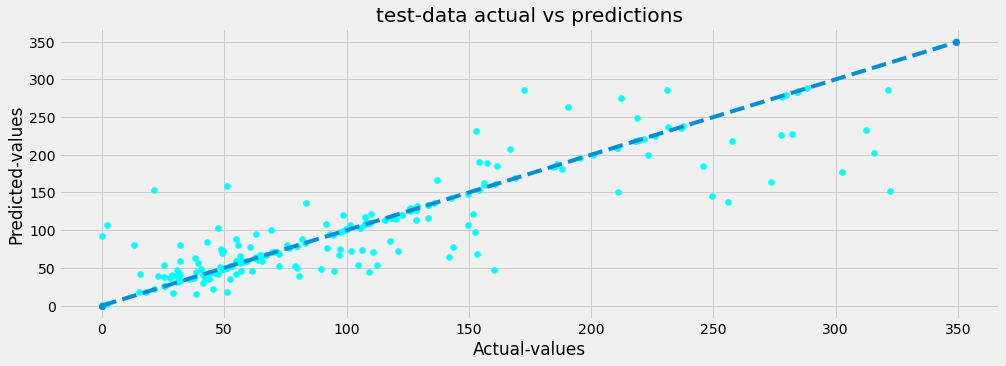

In [34]:
plot_predictions(X_train,X_test, y_train, y_test, regressor)

In [35]:
score = cross_val_score(regressor, X, y, cv=5)

In [36]:
score.mean()

0.7251276747945072